מיני פרוייקט - נושאים בגרפיקה ממוחשבת
רונן פיניש וקמה רפל

In [2]:
dim =32
num_of_angles = 12
num_of_anglesY = 2

In [3]:
def vol2depthmap(v, bg_val=40.):
    #convert volume to depth map
    temp0=np.zeros((dim,dim,7))
    temp1=np.ones((dim,dim,1))
    temp=np.concatenate((temp0, temp1),axis=2)
    temp=np.concatenate((v, temp),axis=2)
    depthmap = temp.argmax(2)
  
    return depthmap

In [4]:
def CreateDepthMapDataset (samples ):
    #create multi matrix of depth map.
    # for each of the objects we do a vector of all the views that we "taking pictures" for this object.

    DepthMapDataset = np.zeros((len(samples),(num_of_angles+num_of_anglesY),dim,dim)) 
    vector_Depth_maps = np.zeros(((num_of_angles+num_of_anglesY),dim,dim))
    for i in range(len(samples)):
        for j in range(num_of_angles):
            vol=ANGLEpointcloud2volumeX(samples[i],j*(360/num_of_angles))
            temp=np.array([vol2depthmap(vol)])
            vector_Depth_maps[j]=temp
        vol=ANGLEpointcloud2volumeY(samples[i],90)
        temp=np.array([vol2depthmap(vol)])
        vector_Depth_maps[num_of_angles]=temp
        vol=ANGLEpointcloud2volumeY(samples[i],270)
        temp=np.array([vol2depthmap(vol)])
        vector_Depth_maps[num_of_angles+1]=temp
            #vol=ANGLEpointcloud2volumeZ(samples[i],j*(360/num_of_angles))
            #temp=np.array([vol2depthmap(vol)])
            #vector_Depth_maps[j+(2*num_of_angles)]=temp
        DepthMapDataset[i]=vector_Depth_maps
    return DepthMapDataset

rotate the object for "taking picture" from 12 angles.
Each function corresponds to a specific axis.
And convert pointcloud to volume

In [5]:
def ANGLEpointcloud2volumeX(pc,angle, dim=32):
    vol = np.zeros((dim,dim,dim))
    tempPC = np.copy(pc)
    
    tempPC = tempPC - [0.5, 0.5, 0.5]
    tempPC = rotateX(tempPC,pc, angle)
# assert tempPC.all()>=-0.5 and tempPC.all()<=0.5, "# debug assertion"
    tempPC = tempPC + [0.5, 0.5, 0.5]
    
    tempPC *= (dim-1) 
    tempPC = tempPC.astype(int)
    tempPC=np.minimum(tempPC,dim-1)
    assert tempPC.all()>=0 and tempPC.all()<=1, "# debug assertion"
    vol[tempPC[:,0],tempPC[:,1],tempPC[:,2]] = 1.0
    return vol

def rotateX(tempPC,pc, angle):
    angle_in_radian=angle*np.pi/180
    (x,y)=tempPC.shape
    rotationMatrix=np.ones(3)
    rotationMatrix=np.array([[1,0,0],
                             [0,np.cos(angle_in_radian),-1*np.sin(angle_in_radian)],
                             [0,np.sin(angle_in_radian),np.cos(angle_in_radian)]])
    tempPC=tempPC.dot(rotationMatrix)
    return tempPC

In [6]:
def ANGLEpointcloud2volumeY(pc,angle, dim=32):
    vol = np.zeros((dim,dim,dim))
    tempPC = np.copy(pc)
    
    tempPC = tempPC - [0.5, 0.5, 0.5]
    tempPC = rotateY(tempPC,pc, angle)
# assert tempPC.all()>=-0.5 and tempPC.all()<=0.5, "# debug assertion"
    tempPC = tempPC + [0.5, 0.5, 0.5]
    
    tempPC *= (dim-1) 
    tempPC = tempPC.astype(int)
    tempPC=np.minimum(tempPC,dim-1)
    assert tempPC.all()>=0 and tempPC.all()<=1, "# debug assertion"
    vol[tempPC[:,0],tempPC[:,1],tempPC[:,2]] = 1.0
    return vol

def rotateY(tempPC,pc, angle):
    angle_in_radian=angle*np.pi/180
    (x,y)=tempPC.shape
    rotationMatrix=np.ones(3)
    rotationMatrix=np.array([[np.cos(angle_in_radian),0,np.sin(angle_in_radian)],
                             [0,1,0],
                             [-1*np.sin(angle_in_radian),0,np.cos(angle_in_radian)]])
    tempPC=tempPC.dot(rotationMatrix)
    return tempPC

In [7]:
def ANGLEpointcloud2volumeZ(pc,angle, dim=32):
    vol = np.zeros((dim,dim,dim))
    tempPC = np.copy(pc)
    
    tempPC = tempPC - [0.5, 0.5, 0.5]
    tempPC = rotateZ(tempPC,pc, angle)
# assert tempPC.all()>=-0.5 and tempPC.all()<=0.5, "# debug assertion"
    tempPC = tempPC + [0.5, 0.5, 0.5]
    
    tempPC *= (dim-1) 
    tempPC = tempPC.astype(int)
    tempPC=np.minimum(tempPC,dim-1)
    assert tempPC.all()>=0 and tempPC.all()<=1, "# debug assertion"
    vol[tempPC[:,0],tempPC[:,1],tempPC[:,2]] = 1.0
    return vol

def rotateZ(tempPC,pc, angle):
    angle_in_radian=angle*np.pi/180
    (x,y)=tempPC.shape
    rotationMatrix=np.ones(3)
    rotationMatrix=np.array([[np.cos(angle_in_radian),-1*np.sin(angle_in_radian),0],
                             [np.sin(angle_in_radian),np.cos(angle_in_radian),0],
                             [0,0,1]])
    tempPC=tempPC.dot(rotationMatrix)
    return tempPC

build the data

In [8]:

import matplotlib as matplotlib
import numpy as np
import keras
from keras import backend as K

batch_size = 128
num_classes = 10

img_rows, img_cols = dim,dim   # input image dimensions

num_views = num_of_angles+num_of_anglesY
########################

# the data, shuffled and split between train and test sets
'''load val'''
ds = np.load('modelnet10_val.npz')
samples = ds['samples']
labels = ds['labels']
samplesData=CreateDepthMapDataset (samples)
'''load train'''
modelnet10_train = np.load('modelnet10_train.npz')
samplesTrain = modelnet10_train['samples']
labelsTrain = modelnet10_train['labels']
samplesDataTrain=CreateDepthMapDataset (samplesTrain)



(x_train, y_train)=(samplesDataTrain, labelsTrain)
(x_test, y_test) = (samplesData, labels)
print (x_train.shape)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0],num_views,1,  img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0],num_views, 1, img_rows, img_cols)
    input_shape = (num_views,1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0],num_views, img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0],num_views, img_rows, img_cols, 1)
    input_shape = (num_views,img_rows, img_cols,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(3991, 14, 32, 32)
x_train shape: (3991, 14, 32, 32, 1)
3991 train samples
908 test samples


In [14]:
#build the model
#trainning and running

import matplotlib as matplotlib
import numpy as np
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input, Conv2D, MaxPooling2D
from keras import backend as K
from split_layer1 import SplitLayer, get_test_shared_model

num_views = num_of_angles+num_of_anglesY
batch_size = 128
num_classes = 10
epochs = 30


########################


#input layer
cnn = get_test_shared_model()
input = keras.layers.Input((num_views, 32, 32, 1))

views = SplitLayer(num_views)(input)

processed_views = [] # empty list
cnn=get_test_shared_model()
for view in views:
    x=cnn(view)
    processed_views.append(x)
    
pooled_views = keras.layers.Maximum()(processed_views)
#x = Conv2D(32, (3, 3), activation='relu')(pooled_views)
#x = keras.layers.Flatten()(x)
x = Dropout(0.25)(pooled_views) 
x = keras.layers.Dense(128)(x)
x = Dropout(0.5)(x) 
x = Dense(num_classes, activation='softmax')(x)
model = keras.models.Model(input, x)

#######################

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 3991 samples, validate on 908 samples
Epoch 1/30
3991/3991 [==============================] - 99s - loss: 2.0388 - acc: 0.2892 - val_loss: 1.7525 - val_acc: 0.4868
Epoch 2/30
3991/3991 [==============================] - 100s - loss: 1.1578 - acc: 0.6414 - val_loss: 0.8756 - val_acc: 0.7137
Epoch 3/30
3991/3991 [==============================] - 99s - loss: 0.6977 - acc: 0.7712 - val_loss: 0.6883 - val_acc: 0.7500
Epoch 4/30
3991/3991 [==============================] - 101s - loss: 0.5589 - acc: 0.8176 - val_loss: 0.5857 - val_acc: 0.7709
Epoch 5/30
3991/3991 [==============================] - 98s - loss: 0.4914 - acc: 0.8421 - val_loss: 0.5042 - val_acc: 0.8172
Epoch 6/30
3991/3991 [==============================] - 95s - loss: 0.4295 - acc: 0.8519 - val_loss: 0.4767 - val_acc: 0.8183
Epoch 7/30
3991/3991 [==============================] - 98s - loss: 0.4059 - acc: 0.8702 - val_loss: 0.4697 - val_acc: 0.8535
Epoch 8/30
3991/3991 [==============================] - 112s - loss: 

In [15]:
def predict_classes(self, x, batch_size=32, verbose=1):
    '''Generate class predictions for the input samples
    batch by batch.
    # Arguments
    x: input data, as a Numpy array or list of Numpy arrays
    (if the model has multiple inputs).
    batch_size: integer.
    verbose: verbosity mode, 0 or 1.
    # Returns
    A numpy array of class predictions.
    '''
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype('int32')

In [16]:
# calculate predictions
predictions = model.predict(x_test,batch_size=10,verbose=0)
# round predictions
rounded = predict_classes(model,x_test)

908/908 [==============================] - 6s     


In [17]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(labels,rounded)

In [18]:
def plot_confusion_matrix (cm, classes, normalize=False, title='confusionmatrix' , cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=90)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalized confusion matrix")
    else:
        print ("confusion matrix, without normalization")
        
   # print (cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i, j], horizontalalignment = "center",color="white" if cm[i,j]>thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion matrix, without normalization
908/908 [==============================] - 6s     

acc: 88.33%


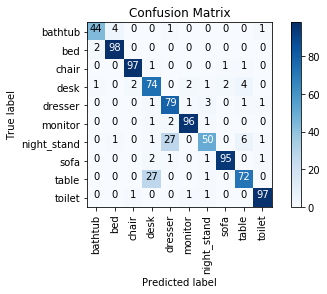

In [19]:
cm_plot_label = ['bathtub', 'bed', 'chair', 'desk', 'dresser','monitor', 'night_stand', 'sofa', 'table', 'toilet']
plot_confusion_matrix(cm,cm_plot_label,title="Confusion Matrix")
#evaluate the model
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))